In [1]:
# # All the imports
%pip install patchify
%pip install GPUtil
%pip install torchsummary
# %pip install torch==2.2.2 torchvision==0.17.2 

Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py) ... - \ done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=b2d836b9a15a6a82b7f167bbe76ed0b35e77534a1aec4a1853c9843334e28ff6
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
# import seaborn as sns
import os
import cv2
# import random
import glob
import PIL
from PIL import Image
from tqdm import tqdm
import imghdr
from patchify import patchify 
import tifffile as tf

from GPUtil import showUtilization as gpu_usage

from skimage.segmentation import find_boundaries
import time
import torch
import torchvision
import torch.optim as optim
import albumentations as A
import torch.nn as nn
import torchvision.transforms.functional as TF
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torch.nn import Dropout
from torchsummary import summary

from torch.nn import BatchNorm2d 
from torchvision.utils import make_grid

from torchvision.transforms import CenterCrop
from torch.nn import functional as F
from torch.nn.functional import normalize

In [3]:
# define the test split
# TEST_SPLIT = 0.3
VALIDATION_SPLIT = 0.3

# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# determine if we will be pinning memory during data loading
# PIN_MEMORY = True if DEVICE == "cuda" else False

# define the number of inputchannels in the input, number of classes,
# and number of levels (start and end) in the U-Net model
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3
START_CHANEL = 16
END_CHANEL = 512
if torch.cuda.is_available() and torch.cuda.device_count() > 0:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    NUM_WORKERS = torch.cuda.device_count()
    print(NUM_WORKERS)
else : 
        NUM_WORKERS = 0 

# initialize learning rate, number of epochs to train for, and the
# batch size ( in general small batch size has 256 samples, here due to 2 batch ss we have )
INIT_LR = 1e-3
NUM_EPOCHS = 200
BATCH_SIZE = 1
PATCH_SIZE = 256
WEIGHT_DECAY = 1e-6

# define the input image dimensions
# INPUT_IMAGE_WIDTH = 2048
# INPUT_IMAGE_HEIGHT = 1536

INPUT_IMAGE_WIDTH = PATCH_SIZE
INPUT_IMAGE_HEIGHT = PATCH_SIZE
NUM_AUGMENTATION = 2

#learning rate scheduler 
Patience = 4
MAX_lr = 1e-1
BASE_lr = 1e-6
STEP_SIZE = 50

# define thresholds for early stopping, for accuracy calculation and predcitions 
EARLY_STOP_THRES = 3
best_accuracy = -1
best_epoch = -1
THRESHOLD = 0.5


plotName = f"bSz{BATCH_SIZE}_ip{PATCH_SIZE}_EnDc{START_CHANEL}-{END_CHANEL}_ep{NUM_EPOCHS}_vls{VALIDATION_SPLIT}_aug{NUM_AUGMENTATION}_nW{NUM_WORKERS}"
print(f'ModelName:-{plotName}')

BASE_OUTPUT = "/kaggle/working/"
# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, f"{plotName}")
# TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

# define the path to the base output directory
gpu_usage() 

Let's use 2 GPUs!
2
ModelName:-bSz1_ip256_EnDc16-512_ep200_vls0.3_aug2_nW2
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  0% |


In [4]:
def plotSanityCheckImages(img1, img2, img3, name):
    
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
    ax[0].imshow(img1)
    ax[1].imshow(img2)
    ax[2].imshow(img3)

    ax[0].set_title("original img")
    ax[1].set_title("mask")
    ax[2].set_title("Boundary")

    figure.suptitle(f"{name}")
    figure.tight_layout()
    figure.show()
    
def collectImagePaths(imgPath, labelPath):
    """Creates a list of image and label paths"""
    imageName = []
    labelName = []
  
    for i, image_name in enumerate(sorted(os.listdir(imgPath))):
            
        if ((('.').join(image_name.split('.')[-1:])== 'tif') or (('.').join(image_name.split('.')[-1:]) == 'tiff')):
            label_name = '.'.join(image_name.split('.')[:-1]) +  '_bn.tif'
            
            if label_name in list(os.listdir(labelPath)): 
                img_Path = os.path.join(imgPath, image_name)
                imageName.append(img_Path)
                
                label_Path = os.path.join(labelPath, label_name)
                labelName.append(label_Path)
            else:
                print(f'{image_name} doesnot have a label')
        return imageName, labelName
                    
    

def readData(imgPath, labelPath, convertType):
    """Reads and creates a list of target"""
    
    length = len(os.listdir(imgPath))
    counter = 0
  
    for i, image_name in enumerate(sorted(os.listdir(imgPath))):
            
        if ((('.').join(image_name.split('.')[-1:])== 'tif') or (('.').join(image_name.split('.')[-1:]) == 'tiff')):
            label_name = '.'.join(image_name.split('.')[:-1]) +  '_bn.tif'
            
            if label_name in list(os.listdir(labelPath)): 
                # normalise by 255.0 -> convert to array -> append to list
                img_Path = os.path.join(imgPath, image_name)
                print(img_Path)
                img = Image.open(img_Path).convert(convertType)
                img = np.array(img, dtype = np.float32)/255.0
                
                label_Path = os.path.join(labelPath, label_name)
                print(label_Path)
                label = Image.open(label_Path).convert(convertType)
                labelB = find_boundaries(np.array(label, dtype = np.uint8), mode = 'thick').astype(np.uint8)
                labelB = np.where(np.array(labelB) > 0, 1.0, 0.0)
                label = np.where(np.array(label) > 0, 1.0, 0.0)
                print(img.shape, labelB.shape)
                counter += 1 
                yield counter, (img, label, labelB, image_name)   
            else:
                continue
                print('Images with no mask-->', image_name)
        else: 
            continue
            print('Image with new extension', image_name)

def readData_length(imgPath, labelPath):
    """Reads and creates a list of target"""
    
    length = len(os.listdir(imgPath))
    counter = 0
  
    for i, image_name in enumerate(sorted(os.listdir(imgPath))):
            
        if ((('.').join(image_name.split('.')[-1:])== 'tif') or (('.').join(image_name.split('.')[-1:]) == 'tiff')):
            label_name = '.'.join(image_name.split('.')[:-1]) +  '_bn.tif'
            
            if label_name in list(os.listdir(labelPath)): 
                counter += 1 

    return counter

# input_folder = '/kaggle/input/myofarm/Images_input'
# label_folder = '/kaggle/input/myofarm/Images_target'
# read_data = readData(input_folder, label_folder, convertType = 'L')
# train_data_length = readData_length(input_folder, label_folder)
# print(train_data_length)
# test_input = '/kaggle/input/myofarm/test_inputs'
# test_mask = '/kaggle/input/myofarm/test_masks'
# read_data = readData(test_input, test_mask, convertType = 'L')
# test_data_length = readData_length(test_input, test_mask)
# print(test_data_length)
# print(next(read_data))


# for i, (length, item) in enumerate(read_data):
# # for i, item in enumerate(read_data):/
#     image, label, labelBoundary, name = item[0], item[1], item[2], item[3]
#     print(i,'--',length,'--', name)
#     if i < 3:
#         plotSanityCheckImages(image, label, labelBoundary, name )

In [5]:
class SpheroidDataset(Dataset):

    def __init__(self, imagePaths, maskPaths, patchSize, convertType, num_augmentations = 0, transforms = None):
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.patchSize = patchSize
        self.transforms = transforms
        self.convertType = convertType
        self.num_augmentations = num_augmentations
    
    def collectImagePaths(self, imgPath, labelPath):
        """Creates a list of image and label paths"""
        imageNames, labelNames = [], []
        for i, image_name in enumerate(sorted(os.listdir(imgPath))):
            if ((('.').join(image_name.split('.')[-1:])== 'tif') 
                or (('.').join(image_name.split('.')[-1:]) == 'tiff')):
                label_name = '.'.join(image_name.split('.')[:-1]) +  '_bn.tif'
                if label_name in list(os.listdir(labelPath)): 
                    img_Path = os.path.join(imgPath, image_name)
                    imageNames.append(img_Path)
                
                    label_Path = os.path.join(labelPath, label_name)
                    labelNames.append(label_Path)
                else:
                    print(f'{image_name} doesnot have a label')
        return imageNames, labelNames
    
    def readData(self, imgPath, labelPath, convertType):
        """"reads the image path and able path"""
        img = Image.open(imgPath).convert(convertType )
        img = np.array(img, dtype = np.float32)/255.0
        
        label = Image.open(labelPath).convert(convertType )
        labelB = find_boundaries(np.array(label, dtype = np.uint8), mode = 'thick').astype(np.uint8)
        kernel = np.ones((5, 5), np.uint8) 
        labelB = np.where(np.array(labelB) > 0, 1.0, 0.0)
        labelB = cv2.dilate(labelB, kernel, iterations = 1)
        label = np.where(np.array(label) > 0, 1.0, 0.0)
        
        return img, label, labelB
    
    def createPatches(self, img, mask, maskB, patchSize):
        """ takes the full image and divides it into resoectuve patches """
        patched_image = patchify(img, (patchSize, patchSize), step=patchSize)
        patched_mask = patchify(mask, (patchSize, patchSize), step=patchSize)
        patched_maskB = patchify(maskB, (patchSize, patchSize), step=patchSize)
        images, masks, maskBs = [], [], []
        for i in range (patched_image.shape[0]):
            for j in range (patched_image.shape[1]):
                patch_img = patched_image[i, j, :, :]
                patch_mask = patched_mask[i, j, :, :]
                patch_maskB = patched_maskB[i, j, :, :]
                
                images.append(torch.tensor(patch_img, dtype = torch.float32).unsqueeze(0))
                masks.append(torch.tensor(patch_mask, dtype = torch.float32).unsqueeze(0))
                maskBs.append(torch.tensor(patch_maskB, dtype = torch.float32).unsqueeze(0))
        return images, masks, maskBs   
    
    def dataTransform(self, image, mask, maskBoundary):
        images_list, masks_list, maskBoundary_list = [], [], []
        transform = A.Compose([
                                A.HorizontalFlip(p = 0.50),
                               A.VerticalFlip(p = 0.50),
                               A.Rotate(p=0.50),
                                A.ShiftScaleRotate(p=0.5),
#                                A.ElasticTransform(p=0.91),
                               A.GridDistortion(p = 0.50),
                              ])
        augmentations = transform(image = np.array(image), masks = [np.array(mask), np.array(maskBoundary)])
        aug = [augmentations["image"], augmentations["masks"][0], augmentations["masks"][1]]
        return aug
    
    def imperativeDataTransform(self, image, mask, maskBoundary):
        images_list, masks_list, maskBoundary_list = [], [], []
        transform = A.Compose([A.GridDistortion(p = 1, num_steps = 10),
                              ])
        augmentations = transform(image = np.array(image), masks = [np.array(mask), np.array(maskBoundary)])
        aug = [augmentations["image"], augmentations["masks"][0], augmentations["masks"][1]]
        return aug
        

    def __len__(self):
        totalImages, totalMasks = self.collectImagePaths(self.imagePaths, self.maskPaths)
        
        if self.num_augmentations > 1:
            length = len(totalImages)* self.num_augmentations
        else:
            length = len(totalImages)
        return length

    def __getitem__(self, idx):
        # read data from the index
        totalImages, totalMasks = self.collectImagePaths(self.imagePaths, self.maskPaths)
        
        # mandatory transformation 
        if self.num_augmentations > 1:
            idx = idx // self.num_augmentations
            ImageDatas = self.readData(totalImages[idx], totalMasks[idx], self.convertType )
            name = totalImages[idx].split('/')[-1:]
            if (idx % self.num_augmentations) != 0: 
                ImageDatas = self.imperativeDataTransform(ImageDatas[0], ImageDatas[1], ImageDatas[2])
        else:
            ImageDatas = self.readData(totalImages[idx], totalMasks[idx], self.convertType )
            name = totalImages[idx].split('/')[-1:]
        
        # perform transfromation 
        if self.transforms == True: #and (idx % self.num_augmentations) == 0:
            ImageDatas = self.dataTransform(ImageDatas[0], ImageDatas[1], ImageDatas[2])
            
        # perform patch creation
        img, mask, maskB = self.createPatches(ImageDatas[0], ImageDatas[1], ImageDatas[2], self.patchSize)
        
        return img, mask, maskB, name
    

#         return image_patch, mask_patch, maskBoundary_patch
PATCH_SIZE = 256
input_folder = '/kaggle/input/myofarm/test_inputs'
label_folder = '/kaggle/input/myofarm/test_masks'
numAug = 0
train_dataset = SpheroidDataset(input_folder, label_folder, patchSize = PATCH_SIZE, 
                          convertType = "L") #, num_augmentations = 0, transforms = True)
print(f'dataset length {len(train_dataset)}')
# SpheroidDataset.readData()

for i, item in enumerate(train_dataset):
    print(f'data index-{i}, -> total #{len(item)}item, -> has #{len(item[0])}patches -> with shape{item[0][0].shape}')
    img =item[0][4].squeeze().numpy()
    mask =item[1][4].squeeze().numpy()
    maskB =item[2][4].squeeze().numpy()
    name = item[3]
    
    # plotSanityCheckImages(item[0], item[1], item[2], f"{item[3]}" )
#     plotSanityCheckImages(img, mask, maskB, f"{item[3]}" ) 
    if i == 2: break
# print(2+2)

dataset length 3
data index-0, -> total #4item, -> has #48patches -> with shapetorch.Size([1, 256, 256])
data index-1, -> total #4item, -> has #48patches -> with shapetorch.Size([1, 256, 256])
data index-2, -> total #4item, -> has #48patches -> with shapetorch.Size([1, 256, 256])


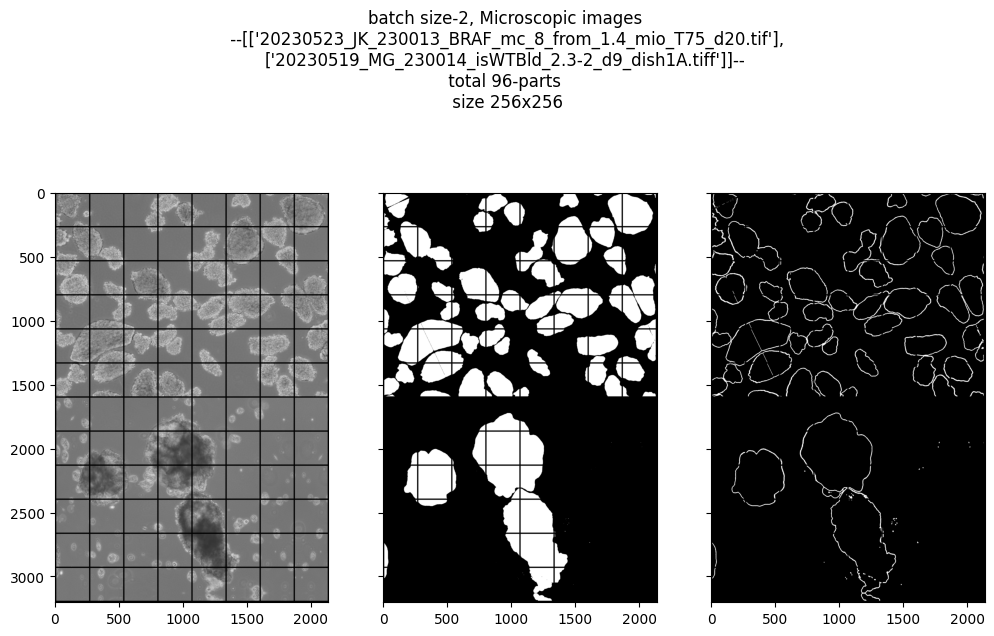

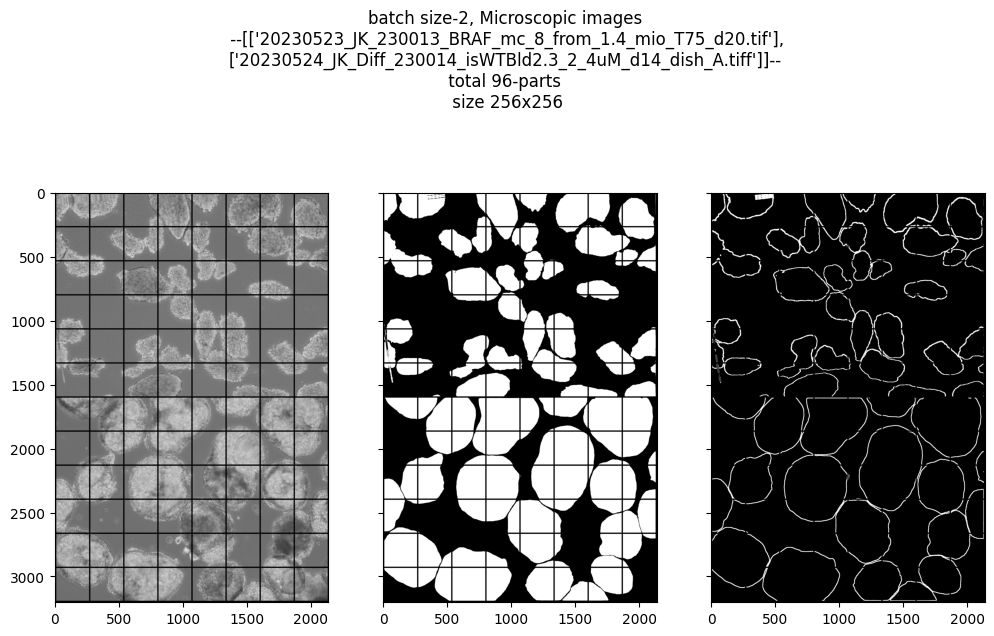

In [6]:
def custom_collate_fn(batch):
    _images, _masks, _maskBs, name = [], [], [], []
    for i, items in enumerate(batch):
        _images.extend(items[0])
        _masks.extend(items[1])
        _maskBs.extend(items[2])
        name.append(items[3])

    images = torch.stack(_images, dim = 0)
    masks = torch.stack(_masks, dim = 0)
    maskBs = torch.stack(_maskBs, dim = 0)
        
    return (images, masks, maskBs), name


def show_batch(data_loader, batch, patchSize, _showMore = None):
    """Plot images grid of single batch"""
    for i, (item, name) in enumerate(data_loader):
        wrapped_title = str(name).replace(", ", ",\n")
#         print(f'{i+1} -> batch, with images {name},\n  -> with each items patched into-{len(item[0])} parts')
        images = item[0]
        mask = item[1]
        maskB = item[2]
        figure, ax = plt.subplots(nrows=1, ncols=3, figsize = (12, 8), sharex=True, sharey=True)
        figure.suptitle(f"batch size-{batch}, Microscopic images\n --{wrapped_title}--\n total {len(item[0])}-parts \n size {patchSize}x{patchSize}", fontsize = 12)
        ax[0].imshow(make_grid(images, nrow = 2*4, padding = 10).permute(1,2,0)) # b is from batch size above cell
        ax[1].imshow(make_grid(mask, nrow = 2*4, padding = 10).permute(1,2,0))
        ax[2].imshow(make_grid(maskB, nrow = 2*4, padding = 10).permute(1,2,0))
        plt.tight_layout
        if (i == 1) and (_showMore == False) :
            break 
            
PATCH_SIZE = 256
BATCH_SIZE = 2
valSplit = 0.3

input_folder = '/kaggle/input/myofarm/test_inputs'
label_folder = '/kaggle/input/myofarm/test_masks'
numAug = 0

train_dataset = SpheroidDataset(input_folder, label_folder, patchSize = PATCH_SIZE, 
                                convertType = "L", num_augmentations = 2, transforms = True)

train_set, validation_set = torch.utils.data.random_split(train_dataset, 
                                                          [round(len(train_dataset) * (1 - valSplit)), 
                                                           round(len(train_dataset) * valSplit)])

trainLoader = DataLoader(dataset = train_set, batch_size = BATCH_SIZE, 
                         collate_fn = custom_collate_fn, num_workers = 0, shuffle =True)
validationLoader = DataLoader(dataset = validation_set, batch_size = BATCH_SIZE, 
                              collate_fn = custom_collate_fn, num_workers = 2, shuffle =True) 

show_batch(trainLoader, batch = BATCH_SIZE, patchSize = PATCH_SIZE, _showMore = True)


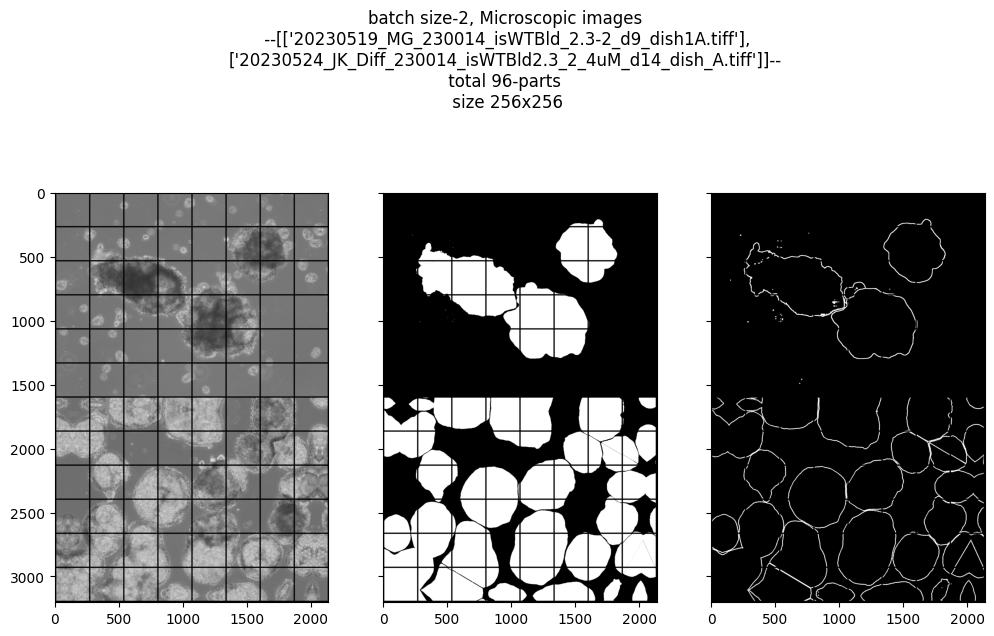

In [7]:
show_batch(validationLoader, batch = BATCH_SIZE, patchSize = PATCH_SIZE, _showMore = True)

## loss functions 

In [8]:
def modelAccuracy(pred, targets):
    # Calculate pixel-wise accuracy
    # assuming input and targets afe falttened
    threshold = 0.5

    targets = torch.where(targets > threshold, torch.tensor(1), torch.tensor(0))
    pred = torch.where(pred > threshold, torch.tensor(1), torch.tensor(0))

    correct = (pred == targets)
    accuracy = correct.sum() / targets.numel()
    
    return accuracy


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, pred, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        pred = pred.view(-1)
        targets = targets.view(-1)
        
        intersection = (pred * targets).sum()                            
        dice = (2.*intersection + smooth)/(pred.sum() + targets.sum() + smooth) 
        accuracy = modelAccuracy(pred, targets)
        
        return 1 - dice, accuracy
    
    
#PyTorch
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, pred, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        pred = pred.view(-1)
        targets = targets.view(-1)
        
        intersection = (pred * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(pred.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(pred, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        accuracy = modelAccuracy(pred, targets)
        
        return Dice_BCE, accuracy
    
#PyTorch
ALPHA = 0.8
GAMMA = 2

class FocalLoss(nn.Module):
    # loss = model_lossFunc(pred.to(torch.float32), y.to(torch.float32))
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, pred, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        pred = pred.view(-1) #model_predictions
        targets = targets.view(-1) #originalMasks
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(pred, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
        
        accuracy = modelAccuracy(pred, targets)
                       
        return focal_loss, accuracy

## model 

In [9]:
def UNETchannels(startChanel, endChanel, num_chanel = NUM_CHANNELS):
    startPower = int(math.log2(startChanel))
    endPower = int(math.log2(endChanel))
    enCh = [num_chanel]
    deCh = []
    for num in range(startPower, endPower+1):
        enCh.append(2**num)
    deCh = enCh[::-1]
    deCh.pop()
    return tuple(enCh), tuple(deCh)

# START_CHANEL = 16
# END_CHANEL = 1024
enCh, deCh = UNETchannels(START_CHANEL, END_CHANEL)


class Block(Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        self.conv1 = nn.Conv2d(inChannels, outChannels,
                            kernel_size=3, stride=1, padding=1, bias=True)
        self.BN1 = nn.BatchNorm2d(outChannels)
        self.relu1 = nn.ReLU(inplace = True)
        self.dropout = nn.Dropout(0.25)
            
        self.conv2 = Conv2d(outChannels, outChannels, 
                            kernel_size=3, stride=1, padding=1, bias=True)
        self.BN2 = BatchNorm2d(outChannels)
        self.relu2 = ReLU(inplace = True)
        
    def forward(self, x):
        # apply CONV => [BN] => RELU => CONV block to the inputs and return it
        outputConv1 = self.dropout(self.relu1(self.BN1(self.conv1(x))))
        outputConv2 = self.relu2(self.BN2(self.conv2(outputConv1))) 
        return outputConv2

In [10]:
class Encoder(Module):    
    def __init__(self, channels = enCh): 
        super().__init__()
        self.encBlocks = ModuleList([Block(channels[i], channels[i + 1]) 
                                      for i in range(len(channels) - 1)])
        self.pool = MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x): 
        blockOutputs = []
        for block in self.encBlocks:
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)

        return blockOutputs
    
    
class DecoderB(Module):
    def __init__(self, channels = deCh):
        super().__init__()

        self.channels = channels
        self.upconvs = ModuleList([ConvTranspose2d(channels[i], channels[i + 1], kernel_size=2, stride=2)
                                   for i in range(len(channels) - 1)])
        self.dec_blocks = ModuleList([Block(channels[i], channels[i + 1])
                                       for i in range(len(channels) - 1)])

    def forward(self, x, encFeatures):

        for i in range(len(self.channels) - 1):
            x = self.upconvs[i](x)
            x = torch.cat([x, encFeatures[i]], dim=1)
            x = self.dec_blocks[i](x)

        return x
    
class Decoder(Module):
    def __init__(self, channels = deCh):
        super().__init__()

        self.channels = channels
        self.upconvs = ModuleList([ConvTranspose2d(channels[i], channels[i + 1], kernel_size=2, stride=2)
                                   for i in range(len(channels) - 1)])
        self.dec_blocks = ModuleList([Block(channels[i], channels[i + 1])
                                       for i in range(len(channels) - 1)])

    def forward(self, x, encFeatures):

        for i in range(len(self.channels) - 1):
            x = self.upconvs[i](x)
            x = torch.cat([x, encFeatures[i]], dim=1)
            x = self.dec_blocks[i](x)

        return x 

class UNet(Module):
        
    def __init__(self, encChannels = enCh,
                 decChannels = deCh, 
                 nbClasses=1, retainDim=True,
                 outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
        super().__init__()
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        self.head = nn.Sequential(nn.Conv2d(decChannels[-1], nbClasses, kernel_size=1),
                                  nn.Sigmoid())
        
        self.decoderB = DecoderB(decChannels)
        self.headB = nn.Sequential(nn.Conv2d(decChannels[-1], nbClasses, kernel_size=1),
                                  nn.Sigmoid())
        self.retainDim = retainDim
        self.outSize = outSize
        
        
    def forward(self, x):
        encFeatures = self.encoder(x)
        decFeatures = self.decoder(encFeatures[::-1][0], encFeatures[::-1][1:])
        mapS = self.head(decFeatures)
        
        decFeaturesB = self.decoderB(encFeatures[::-1][0], encFeatures[::-1][1:])
        mapB = self.headB(decFeaturesB)
        
        if self.retainDim:
            mapS = F.interpolate(mapS, self.outSize)
            mapB = F.interpolate(mapB, self.outSize)

        return mapS, mapB  
from torchsummary import summary
summary(UNet().to(DEVICE), input_size=(1,PATCH_SIZE,PATCH_SIZE))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             160
       BatchNorm2d-2         [-1, 16, 256, 256]              32
              ReLU-3         [-1, 16, 256, 256]               0
           Dropout-4         [-1, 16, 256, 256]               0
            Conv2d-5         [-1, 16, 256, 256]           2,320
       BatchNorm2d-6         [-1, 16, 256, 256]              32
              ReLU-7         [-1, 16, 256, 256]               0
             Block-8         [-1, 16, 256, 256]               0
         MaxPool2d-9         [-1, 16, 128, 128]               0
           Conv2d-10         [-1, 32, 128, 128]           4,640
      BatchNorm2d-11         [-1, 32, 128, 128]              64
             ReLU-12         [-1, 32, 128, 128]               0
          Dropout-13         [-1, 32, 128, 128]               0
           Conv2d-14         [-1, 32, 1

In [11]:
BATCH_SIZE = 1
valSplit = 0.3
# NUM_WORKERS
PATCH_SIZE = 256

input_folder = '/kaggle/input/myofarm/Images_input'
label_folder = '/kaggle/input/myofarm/Images_target'

# train_dataset_1 = SpheroidDataset(input_folder, label_folder,patchSize = PatchSize, transforms = False)
# train_dataset_2 = SpheroidDataset(input_folder, label_folder,patchSize = PatchSize, transforms = True)
from torch.utils.data import ConcatDataset

# train_dataset = ConcatDataset([train_dataset_1, train_dataset_2])
# train_dataset = SpheroidDataset(input_folder, label_folder,patchSize = PatchSize, transforms = False)
train_dataset = SpheroidDataset(input_folder, label_folder, patchSize = PATCH_SIZE, 
                                convertType = "L", num_augmentations = 2, transforms = True)

train_set, validation_set = torch.utils.data.random_split(train_dataset, 
                                                          [round(len(train_dataset) * (1 - valSplit)), 
                                                           round(len(train_dataset) * valSplit)])


trainLoader = DataLoader(dataset = train_set, batch_size = BATCH_SIZE, 
                         collate_fn = custom_collate_fn, num_workers = 2, shuffle = True)
validationLoader = DataLoader(dataset = validation_set, batch_size = BATCH_SIZE, 
                              collate_fn = custom_collate_fn, num_workers = 2, shuffle =True) 

# calculate steps per epoch for training and test set

trainSteps = len(train_set) // BATCH_SIZE
validationSteps = len(validation_set) // BATCH_SIZE

print(f"Total {len(train_set)} instances in the training and {trainSteps} per epoch")
print(f"Total {len(validation_set)} instances in the validation set and {validationSteps} per epoch")
print(f"Each Epoch runs: {len(trainLoader)} times, where each loader has {BATCH_SIZE} instances for trainig")
# print(f"ModelName-{plotName}\n")

unet = UNet()
model = nn.DataParallel(unet)
model.to(DEVICE)
# initialize loss function and optimizerimizer
metric_lossFunc = DiceBCELoss() #nn.BCELoss() #
boundaryLoss = DiceLoss() #FocalLoss() #DiceLoss()
optimizer = optim.Adam(model.parameters(), lr= 1e-4, weight_decay = 1e-6)

print(trainSteps, validationSteps)
print(DEVICE)

Total 171 instances in the training and 171 per epoch
Total 73 instances in the validation set and 73 per epoch
Each Epoch runs: 171 times, where each loader has 1 instances for trainig
171 73
cuda


In [12]:
# def loadOldMode(path):
#     file = glob.glob("*.pth")
#     print(file)
#     model = torch.load(path).to(DEVICE)
#     return model 
# model = loadOldMode('/kaggle/input/test_myotwin/pytorch/unet-bsz2_ip128_endc16-256_ep10/2/bSz1_ip256_EnDc16-512_ep2_vls0.3_aug2_nW2_FullModel.pth')
# print (model)
    

  1%|          | 2/300 [03:30<8:42:01, 105.11s/it]

 =====> Saving the complete model


  1%|▏         | 4/300 [06:59<8:36:27, 104.69s/it]

 =====> Saving the complete model


  2%|▏         | 5/300 [08:43<8:33:00, 104.34s/it]


epoch: 5/300
 -->train_Loss: 1.25594
 -->test_Loss: 1.56672


  2%|▏         | 6/300 [10:26<8:29:34, 103.99s/it]

 =====> Saving the complete model


  3%|▎         | 8/300 [13:53<8:25:10, 103.80s/it]

 =====> Saving the complete model


  3%|▎         | 10/300 [17:20<8:20:39, 103.59s/it]

 =====> Saving the complete model


  4%|▍         | 12/300 [20:50<8:19:42, 104.11s/it]

 =====> Saving the complete model


  5%|▍         | 14/300 [24:19<8:16:53, 104.24s/it]

 =====> Saving the complete model


  5%|▌         | 15/300 [26:02<8:13:54, 103.98s/it]


epoch: 15/300
 -->train_Loss: 0.75117
 -->test_Loss: 1.14695


  5%|▌         | 16/300 [27:45<8:11:31, 103.85s/it]

 =====> Saving the complete model


  6%|▌         | 18/300 [31:14<8:09:19, 104.11s/it]

 =====> Saving the complete model


  7%|▋         | 20/300 [34:41<8:04:27, 103.81s/it]

 =====> Saving the complete model


  7%|▋         | 22/300 [38:09<8:01:11, 103.86s/it]

 =====> Saving the complete model


  8%|▊         | 24/300 [41:36<7:57:46, 103.87s/it]

 =====> Saving the complete model


  8%|▊         | 25/300 [43:20<7:56:14, 103.91s/it]


epoch: 25/300
 -->train_Loss: 0.54090
 -->test_Loss: 0.93506


  9%|▊         | 26/300 [45:05<7:55:27, 104.11s/it]

 =====> Saving the complete model


  9%|▉         | 28/300 [48:33<7:51:57, 104.11s/it]

 =====> Saving the complete model


 10%|█         | 30/300 [52:03<7:50:50, 104.63s/it]

 =====> Saving the complete model


 11%|█         | 32/300 [55:32<7:46:47, 104.50s/it]

 =====> Saving the complete model


 11%|█▏        | 34/300 [59:01<7:43:49, 104.62s/it]

 =====> Saving the complete model


 12%|█▏        | 35/300 [1:00:46<7:42:30, 104.72s/it]


epoch: 35/300
 -->train_Loss: 0.46713
 -->test_Loss: 0.78080


 12%|█▏        | 36/300 [1:02:32<7:41:35, 104.91s/it]

 =====> Saving the complete model


 13%|█▎        | 38/300 [1:06:01<7:37:14, 104.71s/it]

 =====> Saving the complete model


 13%|█▎        | 40/300 [1:09:30<7:33:38, 104.69s/it]

 =====> Saving the complete model


 14%|█▍        | 42/300 [1:12:58<7:28:26, 104.29s/it]

 =====> Saving the complete model


 15%|█▍        | 44/300 [1:16:27<7:26:00, 104.53s/it]

 =====> Saving the complete model


 15%|█▌        | 45/300 [1:18:11<7:22:31, 104.13s/it]


epoch: 45/300
 -->train_Loss: 0.44946
 -->test_Loss: 0.43749


 15%|█▌        | 46/300 [1:19:54<7:19:55, 103.92s/it]

 =====> Saving the complete model


 16%|█▌        | 48/300 [1:23:21<7:15:21, 103.65s/it]

 =====> Saving the complete model


 17%|█▋        | 50/300 [1:26:49<7:12:40, 103.84s/it]

 =====> Saving the complete model


 17%|█▋        | 52/300 [1:30:16<7:08:59, 103.79s/it]

 =====> Saving the complete model


 18%|█▊        | 54/300 [1:33:44<7:05:52, 103.87s/it]

 =====> Saving the complete model


 18%|█▊        | 55/300 [1:35:27<7:03:15, 103.65s/it]


epoch: 55/300
 -->train_Loss: 0.43053
 -->test_Loss: 0.50723


 19%|█▊        | 56/300 [1:37:12<7:02:46, 103.96s/it]

 =====> Saving the complete model


 19%|█▉        | 58/300 [1:40:40<6:59:29, 104.01s/it]

 =====> Saving the complete model


 20%|██        | 60/300 [1:44:09<6:56:58, 104.24s/it]

 =====> Saving the complete model


 21%|██        | 62/300 [1:47:37<6:53:49, 104.33s/it]

 =====> Saving the complete model


 21%|██▏       | 64/300 [1:51:04<6:48:40, 103.90s/it]

 =====> Saving the complete model


 22%|██▏       | 65/300 [1:52:49<6:47:48, 104.12s/it]


epoch: 65/300
 -->train_Loss: 0.42176
 -->test_Loss: 0.41388


 22%|██▏       | 66/300 [1:54:33<6:46:00, 104.10s/it]

 =====> Saving the complete model


 23%|██▎       | 68/300 [1:58:01<6:42:46, 104.17s/it]

 =====> Saving the complete model


 23%|██▎       | 70/300 [2:01:29<6:38:50, 104.04s/it]

 =====> Saving the complete model


 24%|██▍       | 72/300 [2:04:57<6:34:25, 103.79s/it]

 =====> Saving the complete model


 25%|██▍       | 74/300 [2:08:24<6:30:45, 103.74s/it]

 =====> Saving the complete model


 25%|██▌       | 75/300 [2:10:08<6:29:16, 103.80s/it]


epoch: 75/300
 -->train_Loss: 0.41784
 -->test_Loss: 0.37638


 25%|██▌       | 76/300 [2:11:51<6:26:55, 103.64s/it]

 =====> Saving the complete model


 26%|██▌       | 78/300 [2:15:20<6:24:29, 103.92s/it]

 =====> Saving the complete model


 27%|██▋       | 80/300 [2:18:48<6:21:05, 103.93s/it]

 =====> Saving the complete model


 27%|██▋       | 82/300 [2:22:16<6:18:08, 104.08s/it]

 =====> Saving the complete model


 28%|██▊       | 84/300 [2:25:43<6:13:39, 103.79s/it]

 =====> Saving the complete model


 28%|██▊       | 85/300 [2:27:28<6:12:39, 104.00s/it]


epoch: 85/300
 -->train_Loss: 0.40223
 -->test_Loss: 0.35407


 29%|██▊       | 86/300 [2:29:11<6:10:47, 103.96s/it]

 =====> Saving the complete model


 29%|██▉       | 88/300 [2:32:39<6:07:35, 104.04s/it]

 =====> Saving the complete model


 30%|███       | 90/300 [2:36:07<6:03:17, 103.80s/it]

 =====> Saving the complete model


 31%|███       | 92/300 [2:39:35<6:00:14, 103.92s/it]

 =====> Saving the complete model


 31%|███▏      | 94/300 [2:43:02<5:56:44, 103.90s/it]

 =====> Saving the complete model


 32%|███▏      | 95/300 [2:44:47<5:55:26, 104.03s/it]


epoch: 95/300
 -->train_Loss: 0.40129
 -->test_Loss: 0.38183


 32%|███▏      | 96/300 [2:46:31<5:54:19, 104.21s/it]

 =====> Saving the complete model


 33%|███▎      | 98/300 [2:49:59<5:50:24, 104.08s/it]

 =====> Saving the complete model


 33%|███▎      | 100/300 [2:53:26<5:46:07, 103.84s/it]

 =====> Saving the complete model


 34%|███▍      | 102/300 [2:56:54<5:42:59, 103.94s/it]

 =====> Saving the complete model


 35%|███▍      | 104/300 [3:00:23<5:40:00, 104.08s/it]

 =====> Saving the complete model


 35%|███▌      | 105/300 [3:02:06<5:37:45, 103.92s/it]


epoch: 105/300
 -->train_Loss: 0.38591
 -->test_Loss: 0.39042


 35%|███▌      | 106/300 [3:03:50<5:35:23, 103.73s/it]

 =====> Saving the complete model


 36%|███▌      | 108/300 [3:07:18<5:32:36, 103.94s/it]

 =====> Saving the complete model


 37%|███▋      | 110/300 [3:10:46<5:29:10, 103.95s/it]

 =====> Saving the complete model


 37%|███▋      | 112/300 [3:14:13<5:25:07, 103.76s/it]

 =====> Saving the complete model


 38%|███▊      | 114/300 [3:17:42<5:22:32, 104.05s/it]

 =====> Saving the complete model


 38%|███▊      | 115/300 [3:19:26<5:20:52, 104.07s/it]


epoch: 115/300
 -->train_Loss: 0.38907
 -->test_Loss: 0.39266


 39%|███▊      | 116/300 [3:21:10<5:18:58, 104.01s/it]

 =====> Saving the complete model


 39%|███▉      | 118/300 [3:24:38<5:15:57, 104.16s/it]

 =====> Saving the complete model


 40%|████      | 120/300 [3:28:07<5:12:37, 104.21s/it]

 =====> Saving the complete model


 41%|████      | 122/300 [3:31:36<5:09:36, 104.36s/it]

 =====> Saving the complete model


 41%|████▏     | 124/300 [3:35:04<5:06:05, 104.35s/it]

 =====> Saving the complete model


 42%|████▏     | 125/300 [3:36:48<5:03:17, 103.99s/it]


epoch: 125/300
 -->train_Loss: 0.38856
 -->test_Loss: 0.33851


 42%|████▏     | 126/300 [3:38:31<5:01:06, 103.83s/it]

 =====> Saving the complete model


 43%|████▎     | 128/300 [3:41:59<4:58:07, 104.00s/it]

 =====> Saving the complete model


 43%|████▎     | 130/300 [3:45:25<4:53:03, 103.43s/it]

 =====> Saving the complete model


 44%|████▍     | 132/300 [3:48:53<4:50:14, 103.66s/it]

 =====> Saving the complete model


 45%|████▍     | 134/300 [3:52:20<4:46:05, 103.41s/it]

 =====> Saving the complete model


 45%|████▌     | 135/300 [3:54:03<4:44:22, 103.41s/it]


epoch: 135/300
 -->train_Loss: 0.38079
 -->test_Loss: 0.38528


 45%|████▌     | 136/300 [3:55:46<4:41:55, 103.15s/it]

 =====> Saving the complete model


 46%|████▌     | 138/300 [3:59:13<4:39:01, 103.34s/it]

 =====> Saving the complete model


 47%|████▋     | 140/300 [4:02:40<4:36:02, 103.52s/it]

 =====> Saving the complete model


 47%|████▋     | 142/300 [4:06:09<4:33:29, 103.86s/it]

 =====> Saving the complete model


 48%|████▊     | 144/300 [4:09:35<4:29:31, 103.66s/it]

 =====> Saving the complete model


 48%|████▊     | 145/300 [4:11:18<4:27:13, 103.44s/it]


epoch: 145/300
 -->train_Loss: 0.37769
 -->test_Loss: 0.35718


 49%|████▊     | 146/300 [4:13:02<4:25:42, 103.52s/it]

 =====> Saving the complete model


 49%|████▉     | 148/300 [4:16:30<4:22:48, 103.74s/it]

 =====> Saving the complete model


 50%|█████     | 150/300 [4:19:58<4:19:49, 103.93s/it]

 =====> Saving the complete model


 51%|█████     | 152/300 [4:23:26<4:16:42, 104.07s/it]

 =====> Saving the complete model


 51%|█████▏    | 154/300 [4:26:53<4:12:32, 103.79s/it]

 =====> Saving the complete model


 52%|█████▏    | 155/300 [4:28:37<4:10:53, 103.82s/it]


epoch: 155/300
 -->train_Loss: 0.37214
 -->test_Loss: 0.36918


 52%|█████▏    | 156/300 [4:30:22<4:09:48, 104.08s/it]

 =====> Saving the complete model


 53%|█████▎    | 158/300 [4:33:50<4:06:22, 104.10s/it]

 =====> Saving the complete model


 53%|█████▎    | 160/300 [4:37:19<4:02:55, 104.11s/it]

 =====> Saving the complete model


 54%|█████▍    | 162/300 [4:40:47<3:59:38, 104.19s/it]

 =====> Saving the complete model


 55%|█████▍    | 164/300 [4:44:16<3:56:11, 104.20s/it]

 =====> Saving the complete model


 55%|█████▌    | 165/300 [4:45:59<3:54:03, 104.03s/it]


epoch: 165/300
 -->train_Loss: 0.37559
 -->test_Loss: 0.36770


 55%|█████▌    | 166/300 [4:47:44<3:52:38, 104.17s/it]

 =====> Saving the complete model


 56%|█████▌    | 168/300 [4:51:12<3:48:53, 104.04s/it]

 =====> Saving the complete model


 57%|█████▋    | 170/300 [4:54:39<3:44:49, 103.76s/it]

 =====> Saving the complete model


 57%|█████▋    | 172/300 [4:58:05<3:40:54, 103.55s/it]

 =====> Saving the complete model


 58%|█████▊    | 174/300 [5:01:32<3:37:05, 103.38s/it]

 =====> Saving the complete model


 58%|█████▊    | 175/300 [5:03:15<3:35:20, 103.36s/it]


epoch: 175/300
 -->train_Loss: 0.35740
 -->test_Loss: 0.33934


 59%|█████▊    | 176/300 [5:04:59<3:33:38, 103.38s/it]

 =====> Saving the complete model


 59%|█████▉    | 178/300 [5:08:26<3:30:44, 103.64s/it]

 =====> Saving the complete model


 60%|██████    | 180/300 [5:11:54<3:27:14, 103.62s/it]

 =====> Saving the complete model


 61%|██████    | 182/300 [5:15:22<3:24:22, 103.92s/it]

 =====> Saving the complete model


 61%|██████▏   | 184/300 [5:18:51<3:21:12, 104.07s/it]

 =====> Saving the complete model


 62%|██████▏   | 185/300 [5:20:34<3:19:20, 104.01s/it]


epoch: 185/300
 -->train_Loss: 0.38945
 -->test_Loss: 0.33694


 62%|██████▏   | 186/300 [5:22:19<3:17:46, 104.10s/it]

 =====> Saving the complete model


 63%|██████▎   | 188/300 [5:25:47<3:14:07, 104.00s/it]

 =====> Saving the complete model


 63%|██████▎   | 190/300 [5:29:15<3:11:04, 104.23s/it]

 =====> Saving the complete model


 64%|██████▍   | 192/300 [5:32:43<3:07:23, 104.11s/it]

 =====> Saving the complete model


 65%|██████▍   | 194/300 [5:36:11<3:03:40, 103.97s/it]

 =====> Saving the complete model


 65%|██████▌   | 195/300 [5:37:55<3:01:52, 103.93s/it]


epoch: 195/300
 -->train_Loss: 0.35284
 -->test_Loss: 0.34237


 65%|██████▌   | 196/300 [5:39:39<3:00:10, 103.94s/it]

 =====> Saving the complete model


 66%|██████▌   | 198/300 [5:43:09<2:57:39, 104.50s/it]

 =====> Saving the complete model


 67%|██████▋   | 200/300 [5:46:36<2:53:15, 103.95s/it]

 =====> Saving the complete model


 67%|██████▋   | 202/300 [5:50:03<2:49:28, 103.76s/it]

 =====> Saving the complete model


 68%|██████▊   | 204/300 [5:53:31<2:46:11, 103.87s/it]

 =====> Saving the complete model


 68%|██████▊   | 205/300 [5:55:14<2:44:25, 103.85s/it]


epoch: 205/300
 -->train_Loss: 0.35504
 -->test_Loss: 0.34688


 69%|██████▊   | 206/300 [5:56:59<2:43:02, 104.07s/it]

 =====> Saving the complete model


 69%|██████▉   | 208/300 [6:00:27<2:39:27, 103.99s/it]

 =====> Saving the complete model


 70%|███████   | 210/300 [6:03:56<2:36:25, 104.28s/it]

 =====> Saving the complete model


 71%|███████   | 212/300 [6:07:24<2:32:56, 104.28s/it]

 =====> Saving the complete model


 71%|███████▏  | 214/300 [6:10:54<2:29:45, 104.48s/it]

 =====> Saving the complete model


 72%|███████▏  | 215/300 [6:12:38<2:27:51, 104.37s/it]


epoch: 215/300
 -->train_Loss: 0.38912
 -->test_Loss: 0.36067


 72%|███████▏  | 216/300 [6:14:22<2:26:07, 104.37s/it]

 =====> Saving the complete model


 73%|███████▎  | 218/300 [6:17:51<2:22:38, 104.37s/it]

 =====> Saving the complete model


 73%|███████▎  | 220/300 [6:21:20<2:19:15, 104.44s/it]

 =====> Saving the complete model


 74%|███████▍  | 222/300 [6:24:49<2:15:50, 104.49s/it]

 =====> Saving the complete model


 75%|███████▍  | 224/300 [6:28:18<2:12:30, 104.62s/it]

 =====> Saving the complete model


 75%|███████▌  | 225/300 [6:30:04<2:11:04, 104.86s/it]


epoch: 225/300
 -->train_Loss: 0.34222
 -->test_Loss: 0.35055


 75%|███████▌  | 226/300 [6:31:48<2:08:56, 104.55s/it]

 =====> Saving the complete model


 76%|███████▌  | 228/300 [6:35:16<2:05:14, 104.36s/it]

 =====> Saving the complete model


 77%|███████▋  | 230/300 [6:38:45<2:01:54, 104.49s/it]

 =====> Saving the complete model


 77%|███████▋  | 232/300 [6:42:13<1:58:15, 104.35s/it]

 =====> Saving the complete model


 78%|███████▊  | 234/300 [6:45:42<1:54:49, 104.39s/it]

 =====> Saving the complete model


 78%|███████▊  | 235/300 [6:47:26<1:52:51, 104.18s/it]


epoch: 235/300
 -->train_Loss: 0.33789
 -->test_Loss: 0.33632


 79%|███████▊  | 236/300 [6:49:10<1:51:11, 104.24s/it]

 =====> Saving the complete model


 79%|███████▉  | 238/300 [6:52:38<1:47:28, 104.01s/it]

 =====> Saving the complete model


 80%|████████  | 240/300 [6:56:06<1:44:12, 104.21s/it]

 =====> Saving the complete model


 81%|████████  | 242/300 [6:59:35<1:40:43, 104.19s/it]

 =====> Saving the complete model


 81%|████████▏ | 244/300 [7:03:03<1:37:15, 104.20s/it]

 =====> Saving the complete model


 82%|████████▏ | 245/300 [7:04:47<1:35:29, 104.18s/it]


epoch: 245/300
 -->train_Loss: 0.43857
 -->test_Loss: 0.35380


 82%|████████▏ | 246/300 [7:06:31<1:33:41, 104.10s/it]

 =====> Saving the complete model


 83%|████████▎ | 248/300 [7:10:00<1:30:27, 104.38s/it]

 =====> Saving the complete model


 83%|████████▎ | 250/300 [7:13:29<1:26:53, 104.28s/it]

 =====> Saving the complete model


 84%|████████▍ | 252/300 [7:16:58<1:23:27, 104.32s/it]

 =====> Saving the complete model


 85%|████████▍ | 254/300 [7:20:26<1:20:02, 104.41s/it]

 =====> Saving the complete model


 85%|████████▌ | 255/300 [7:22:11<1:18:16, 104.37s/it]


epoch: 255/300
 -->train_Loss: 0.33316
 -->test_Loss: 0.33682


 85%|████████▌ | 256/300 [7:23:55<1:16:29, 104.30s/it]

 =====> Saving the complete model


 86%|████████▌ | 258/300 [7:27:25<1:13:19, 104.75s/it]

 =====> Saving the complete model


 87%|████████▋ | 260/300 [7:30:54<1:09:42, 104.56s/it]

 =====> Saving the complete model


 87%|████████▋ | 262/300 [7:34:23<1:06:08, 104.45s/it]

 =====> Saving the complete model


 88%|████████▊ | 264/300 [7:37:51<1:02:35, 104.31s/it]

 =====> Saving the complete model


 88%|████████▊ | 265/300 [7:39:35<1:00:44, 104.13s/it]


epoch: 265/300
 -->train_Loss: 0.34194
 -->test_Loss: 0.34948


 89%|████████▊ | 266/300 [7:41:21<59:17, 104.64s/it]  

 =====> Saving the complete model


 89%|████████▉ | 268/300 [7:44:49<55:40, 104.40s/it]

 =====> Saving the complete model


 90%|█████████ | 270/300 [7:48:19<52:21, 104.73s/it]

 =====> Saving the complete model


 91%|█████████ | 272/300 [7:51:47<48:40, 104.32s/it]

 =====> Saving the complete model


 91%|█████████▏| 274/300 [7:55:17<45:21, 104.69s/it]

 =====> Saving the complete model


 92%|█████████▏| 275/300 [7:57:02<43:36, 104.67s/it]


epoch: 275/300
 -->train_Loss: 0.35522
 -->test_Loss: 0.35910


 92%|█████████▏| 276/300 [7:58:47<41:54, 104.79s/it]

 =====> Saving the complete model


 93%|█████████▎| 278/300 [8:02:16<38:24, 104.76s/it]

 =====> Saving the complete model


 93%|█████████▎| 280/300 [8:05:44<34:45, 104.27s/it]

 =====> Saving the complete model


 94%|█████████▍| 282/300 [8:09:13<31:18, 104.38s/it]

 =====> Saving the complete model


 95%|█████████▍| 284/300 [8:12:41<27:50, 104.42s/it]

 =====> Saving the complete model


 95%|█████████▌| 285/300 [8:14:26<26:05, 104.34s/it]


epoch: 285/300
 -->train_Loss: 0.33612
 -->test_Loss: 0.34617


 95%|█████████▌| 286/300 [8:16:09<24:18, 104.19s/it]

 =====> Saving the complete model


 96%|█████████▌| 288/300 [8:19:39<20:52, 104.41s/it]

 =====> Saving the complete model


 97%|█████████▋| 290/300 [8:23:06<17:19, 103.90s/it]

 =====> Saving the complete model


 97%|█████████▋| 292/300 [8:26:33<13:49, 103.66s/it]

 =====> Saving the complete model


 98%|█████████▊| 294/300 [8:30:01<10:24, 104.03s/it]

 =====> Saving the complete model


 98%|█████████▊| 295/300 [8:31:45<08:40, 104.12s/it]


epoch: 295/300
 -->train_Loss: 0.33063
 -->test_Loss: 0.34173


 99%|█████████▊| 296/300 [8:33:31<06:58, 104.59s/it]

 =====> Saving the complete model


 99%|█████████▉| 298/300 [8:36:59<03:28, 104.21s/it]

 =====> Saving the complete model


100%|██████████| 300/300 [8:40:28<00:00, 104.09s/it]

 =====> Saving the complete model


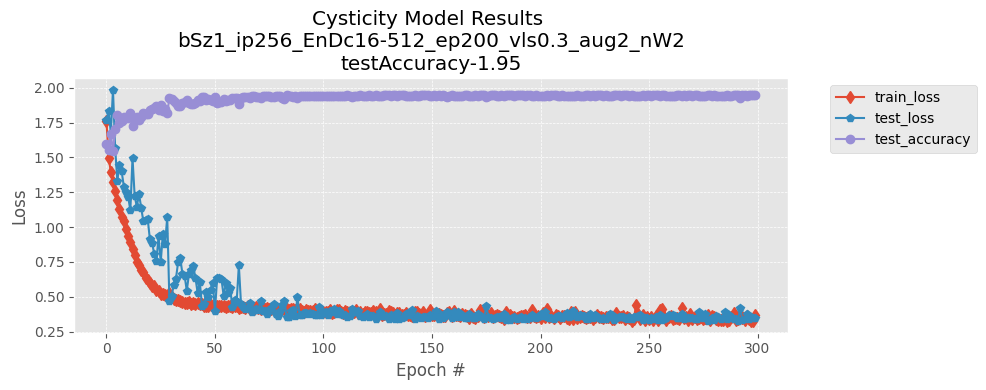

bSz1_ip256_EnDc16-512_ep200_vls0.3_aug2_nW2
| ID | GPU | MEM |
------------------
|  0 | 39% |  4% |
|  1 | 11% |  1% |
None


In [13]:
def save_checkpoint(_model = None, _modelName = None, _file_path = None):
    print(" =====> Saving the complete model")
    if _file_path == None: 
        _file_path = pwd() + f"/{_modelName}_FullModel.pth"
    else: 
        _file_path = _file_path + f"/{_modelName}_FullModel.pth"
    torch.save(_model, _file_path)
    return _file_path

def plotLossAccResults(_train_loss, _test_loss, _test_acc, _modelName):
    plt.figure(figsize=(10, 4))
    plt.style.use("ggplot")

    plt.plot(_train_loss, label="train_loss", marker='d')
    plt.plot(_test_loss, label="test_loss", marker='p')
    plt.plot(_test_acc, label="test_accuracy", marker='o')

    plt.title(f"Cysticity Model Results \n{_modelName}\ntestAccuracy-{_test_acc[-1]:.2f}") 
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#     plt.xticks(np.arange(0, len(train_loss), 1))
#     plt.yticks(np.arange(0, max(test_loss), 0.1))

    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.tight_layout()
    plt.show()
    return

def trainLoop(epoch, _dataLoader, model, device):
    model.train()
    total_loss, total_accuracy = 0, 0
    b_loss = 0
    for i, (batch, name) in enumerate(_dataLoader):
        # print(batch[0])
        img = batch[0].to(device)
        mask = batch[1].to(device)
        maskB = batch[2].to(device)
        
        mask_pred, boundary_pred = model(img)
        loss, accuracy = metric_lossFunc(mask_pred, mask)
        lossB, accuracyB = boundaryLoss(boundary_pred, maskB)
        combined_loss = loss + lossB

        optimizer.zero_grad()
        combined_loss.backward()
        optimizer.step()

        total_loss += combined_loss.item()
        b_loss += lossB.item()
        total_accuracy += accuracy.item() + accuracyB.item()
#     print(f'Training epoch-{epoch+1}, total_loss-{total_loss/len(_dataLoader)}, boundaryLoss-{b_loss/len(_dataLoader)}')
    return total_loss/len(_dataLoader), total_accuracy/len(_dataLoader)


def validationLoop(epoch, _dataLoader, model, device):
    total_loss, total_accuracy = 0, 0
    b_loss = 0
    model.eval()
    with torch.no_grad():        
        for i, (batch, name) in enumerate(_dataLoader):              
            # print(batch[0])
            img = batch[0].to(device)
            mask = batch[1].to(device)
            maskB = batch[2].to(device)
            
            mask_pred, boundary_pred = model(img)
            loss, accuracy = metric_lossFunc(mask_pred, mask)
            lossB, accuracyB = boundaryLoss(boundary_pred, maskB)
            combined_loss = loss + lossB
            
            b_loss += lossB.item()
            total_loss += combined_loss.item()
            total_accuracy += accuracy.item() + accuracyB.item()
#     print(f'Validation epoch-{epoch+1}, total_loss-{total_loss/len(_dataLoader)}, boundaryLoss-{b_loss/len(_dataLoader)}') #, total_accuracy-{total_accuracy/len(_dataLoader)}')
    return total_loss/len(_dataLoader), total_accuracy/len(_dataLoader)
    
        
train_loss, train_acc = [], []
test_loss, test_acc = [], []
NUM_EPOCHS = 300
for epoch in tqdm(range(NUM_EPOCHS)):

    loss, acc = trainLoop(epoch, trainLoader, model, DEVICE)
    train_loss.append(loss)
    train_acc.append(acc)

    loss, acc = validationLoop(epoch, validationLoader, model, DEVICE)
    test_loss.append(loss)
    test_acc.append(acc)

    if (epoch+1)%2 == 0:
        modelFilePath = save_checkpoint(_model = model, _modelName = plotName, _file_path = BASE_OUTPUT) 
    elif (epoch+1)%5 == 0:
        print(f'\nepoch: {epoch+1}/{NUM_EPOCHS}\n -->train_Loss: {train_loss[epoch]:.5f}\n -->test_Loss: {test_loss[epoch]:.5f}') #\n -->test_acc: {test_acc[epoch]:.5f}\n')
        
plotLossAccResults(train_loss, test_loss, test_acc, _modelName = plotName)
print(plotName)   
with torch.no_grad():
    torch.cuda.empty_cache()
print(gpu_usage())

In [14]:
"""""""""
    0%|          | 0/10 [00:00<?, ?it/s]
Training epoch-1, total_loss-0.5206698701662176, boundaryLoss-0.011988759796847315
 10%|█         | 1/10 [00:52<07:54, 52.77s/it]
Validation epoch-1, total_loss-1.0161057017944954, boundaryLoss-0.013568529129229687
Training epoch-2, total_loss-0.5004973541287815, boundaryLoss-0.010854789844768889
 20%|██        | 2/10 [01:45<07:00, 52.52s/it]
Validation epoch-2, total_loss-0.8850055224186665, boundaryLoss-0.011409097263035742
 =====> Saving the complete model

epoch: 2/10
 -->train_Loss: 0.50050
 -->test_Loss: 0.88501
Training epoch-3, total_loss-0.47947044512804815, boundaryLoss-0.009977375677622417
 30%|███       | 3/10 [02:37<06:07, 52.51s/it]
Validation epoch-3, total_loss-0.9980188028232472, boundaryLoss-0.011406150545824218
Training epoch-4, total_loss-0.47174868864171643, boundaryLoss-0.009231664163663106
 40%|████      | 4/10 [03:30<05:16, 52.68s/it]
Validation epoch-4, total_loss-1.0206184838269208, boundaryLoss-0.010200532618910074
 =====> Saving the complete model

epoch: 4/10
 -->train_Loss: 0.47175
 -->test_Loss: 1.02062
Training epoch-5, total_loss-0.4540742607677684, boundaryLoss-0.008514194858863074
 50%|█████     | 5/10 [04:23<04:23, 52.73s/it]
Validation epoch-5, total_loss-0.9381103000125369, boundaryLoss-0.009708744914245766
Training epoch-6, total_loss-0.432017881379408, boundaryLoss-0.007787156817229355
 60%|██████    | 6/10 [05:16<03:30, 52.73s/it]
Validation epoch-6, total_loss-0.8375895466353442, boundaryLoss-0.008963900542742497
 =====> Saving the complete model

epoch: 6/10
 -->train_Loss: 0.43202
 -->test_Loss: 0.83759
Training epoch-7, total_loss-0.42202916653717265, boundaryLoss-0.007160181886352161
 70%|███████   | 7/10 [06:08<02:37, 52.65s/it]
Validation epoch-7, total_loss-1.0679936110973358, boundaryLoss-0.00897046789602452
Training epoch-8, total_loss-0.4054894449079738, boundaryLoss-0.006782345534028376
 80%|████████  | 8/10 [07:01<01:45, 52.59s/it]
Validation epoch-8, total_loss-0.7492141240351909, boundaryLoss-0.00798833673517849
 =====> Saving the complete model

epoch: 8/10
 -->train_Loss: 0.40549
 -->test_Loss: 0.74921
Training epoch-9, total_loss-0.39276371177505043, boundaryLoss-0.006277350738973302
 90%|█████████ | 9/10 [07:53<00:52, 52.58s/it]
Validation epoch-9, total_loss-0.8843226223378569, boundaryLoss-0.007621034023326797
Training epoch-10, total_loss-0.37674674374215744, boundaryLoss-0.005813371439409606
100%|██████████| 10/10 [08:46<00:00, 52.62s/it]
Validation epoch-10, total_loss-1.0979174150002968, boundaryLoss-0.0070558851930891744
 =====> Saving the complete model

epoch: 10/10
 -->train_Loss: 0.37675
 -->test_Loss: 1.09792
    
"""""""""

'\n    0%|          | 0/10 [00:00<?, ?it/s]\nTraining epoch-1, total_loss-0.5206698701662176, boundaryLoss-0.011988759796847315\n 10%|█         | 1/10 [00:52<07:54, 52.77s/it]\nValidation epoch-1, total_loss-1.0161057017944954, boundaryLoss-0.013568529129229687\nTraining epoch-2, total_loss-0.5004973541287815, boundaryLoss-0.010854789844768889\n 20%|██        | 2/10 [01:45<07:00, 52.52s/it]\nValidation epoch-2, total_loss-0.8850055224186665, boundaryLoss-0.011409097263035742\n =====> Saving the complete model\n\nepoch: 2/10\n -->train_Loss: 0.50050\n -->test_Loss: 0.88501\nTraining epoch-3, total_loss-0.47947044512804815, boundaryLoss-0.009977375677622417\n 30%|███       | 3/10 [02:37<06:07, 52.51s/it]\nValidation epoch-3, total_loss-0.9980188028232472, boundaryLoss-0.011406150545824218\nTraining epoch-4, total_loss-0.47174868864171643, boundaryLoss-0.009231664163663106\n 40%|████      | 4/10 [03:30<05:16, 52.68s/it]\nValidation epoch-4, total_loss-1.0206184838269208, boundaryLoss-0.01

In [15]:
def prepare_plot(origImage, origMask, origMaskBoundary, predMask, predMaskBoundary, file, threshold = None):
    # initialize our figure
    figure, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
    ax[0][0].imshow(origImage)
    ax[0][1].imshow(origMask)
    ax[0][2].imshow(predMask)
    ax[1][0].imshow(origMaskBoundary)
    ax[1][1].imshow(predMaskBoundary)
    ax[1][2].imshow(predMask)
#     ax[3].imshow(predMask > (predMask.max() - threshold))
#     ax[3].hist(predMask.flatten()*255)

    ax[0][0].set_title(f"{file}")
    ax[0][1].set_title("Original Mask")
    ax[0][2].set_title(f"P_Mask-{threshold}thresh")
    ax[1][0].set_title(f"orig Boundary")
    ax[1][1].set_title("pred Mask Boundary")
    ax[1][2].set_title(f"All combined")
#     ax[3].set_title('P_mask w threshold')

    figure.tight_layout()
    figure.show()

def make_predictions(model, file, imagePath, groundTruthPath, patch_size, threshold = None):
    model.eval()
    with torch.no_grad():
        image = Image.open(imagePath).convert("L")
        image = np.float32(image)/255.0
        
        gtMask = np.array(Image.open(groundTruthPath).convert("L"))
        gtMask[gtMask > 0] = 1.0
        gtMask_Boundary = find_boundaries(np.array(Image.open(groundTruthPath).convert("L")), mode='thick').astype(np.uint8)
#         find_boundaries(np.array(img), mode='thick').astype(np.uint8)
        #gtMask_Boundary = np.where(np.array(gtMask_Boundary) > 0, 1.0, 0.0)
        gtMask_Boundary[gtMask_Boundary > 0] = 1.0
    
        height, width = image.shape[:2]
        segm_img = np.zeros((height, width), dtype=np.uint8)  # Array with zeros to be filled with segmented values
        segmBoundary_img = np.zeros((height, width), dtype=np.uint8)
    
        patch_num = 1
    
        for i in range(0, height, patch_size):  
            for j in range(0, width, patch_size):  
                single_patch = image[i:i+patch_size, j:j+patch_size]
                single_patch = np.expand_dims(np.expand_dims(single_patch, 0), 0)
                orig_patch = single_patch.copy()
                single_patch = torch.from_numpy(single_patch).to(DEVICE)
                
                Mask_patch = gtMask[i:i+patch_size, j:j+patch_size]
               
                # pass the results through the sigmoid if the last layer of the model doesnot do sigmoid conversion
                # single_patch_prediction = torch.sigmoid(model(single_patch)).squeeze().cpu().numpy()
                single_patch_prediction, singleBoundary_patch_prediction = model(single_patch) #.squeeze().cpu().numpy()
                
                # filter out the weak predictions and convert them to integers
                single_patch_prediction = ((single_patch_prediction.squeeze().cpu().numpy() > threshold)*255).astype(np.uint8)
                single_patch_shape = single_patch_prediction.shape[:2]
                segm_img[i:i+single_patch_shape[0], j:j+single_patch_shape[1]] += cv2.resize(single_patch_prediction, single_patch_shape[::-1])
                
                singleBoundary_patch_prediction = ((singleBoundary_patch_prediction.squeeze().cpu().numpy())).astype(np.uint8)
#                 singleBoundary_patch_prediction = ((singleBoundary_patch_prediction.squeeze().cpu().numpy() > threshold)*255).astype(np.uint8)
                single_patch_shape = singleBoundary_patch_prediction.shape[:2]
#                 plt.imshow(singleBoundary_patch_prediction)
#                 plt.show()
                segmBoundary_img[i:i+single_patch_shape[0], j:j+single_patch_shape[1]] += cv2.resize(singleBoundary_patch_prediction, single_patch_shape[::-1])
                # print("Finished processing patch number ", patch_num, " at position ", i, j)
            
            patch_num += 1  
        print(singleBoundary_patch_prediction.max(), singleBoundary_patch_prediction.min())

    prepare_plot(image, gtMask, gtMask_Boundary, segm_img, segmBoundary_img, file, threshold)
    return single_patch_prediction

[INFO] load up model...
/kaggle/working//bSz1_ip256_EnDc16-512_ep200_vls0.3_aug2_nW2_FullModel.pth
[INFO] loading up test image paths...

1 0
1 0
1 0


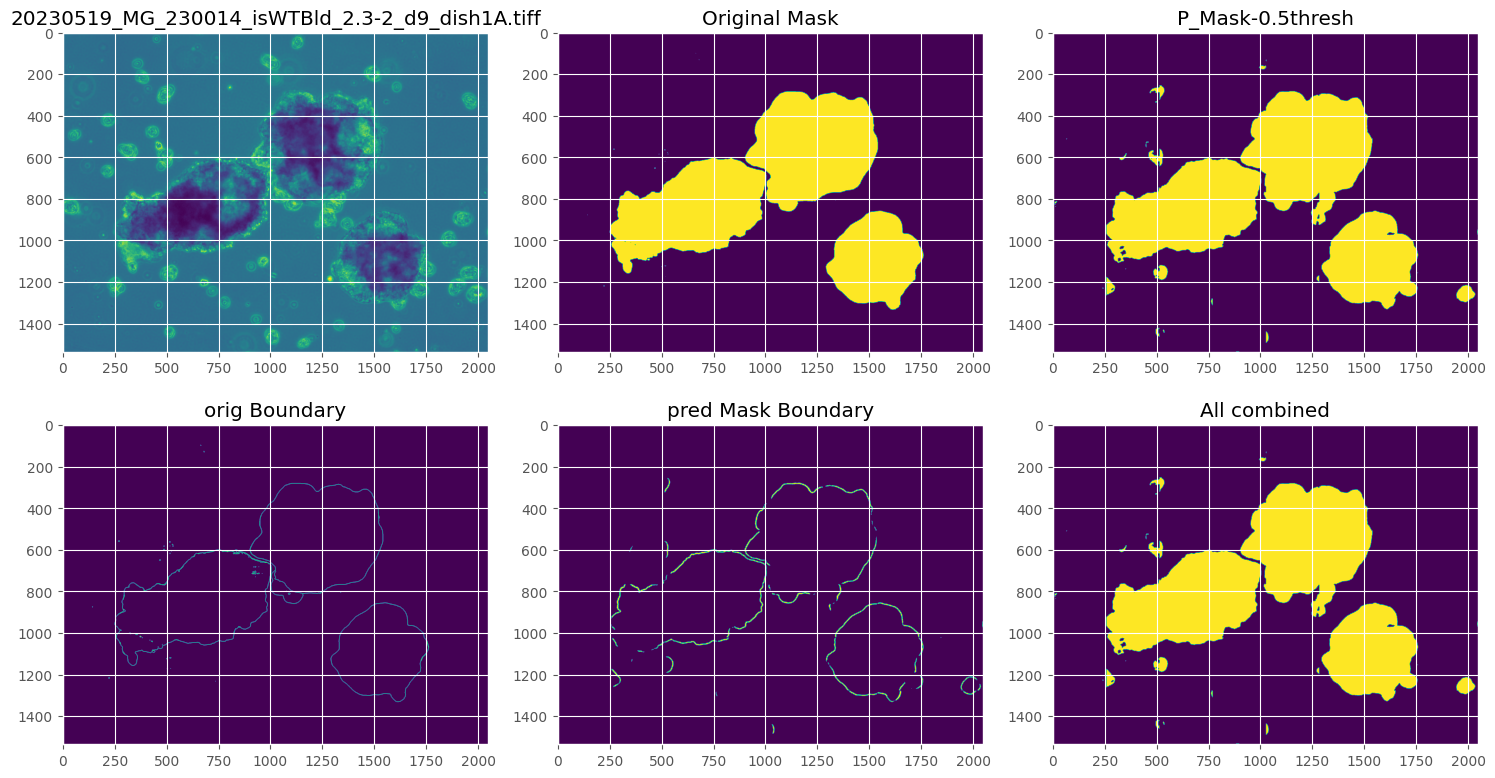

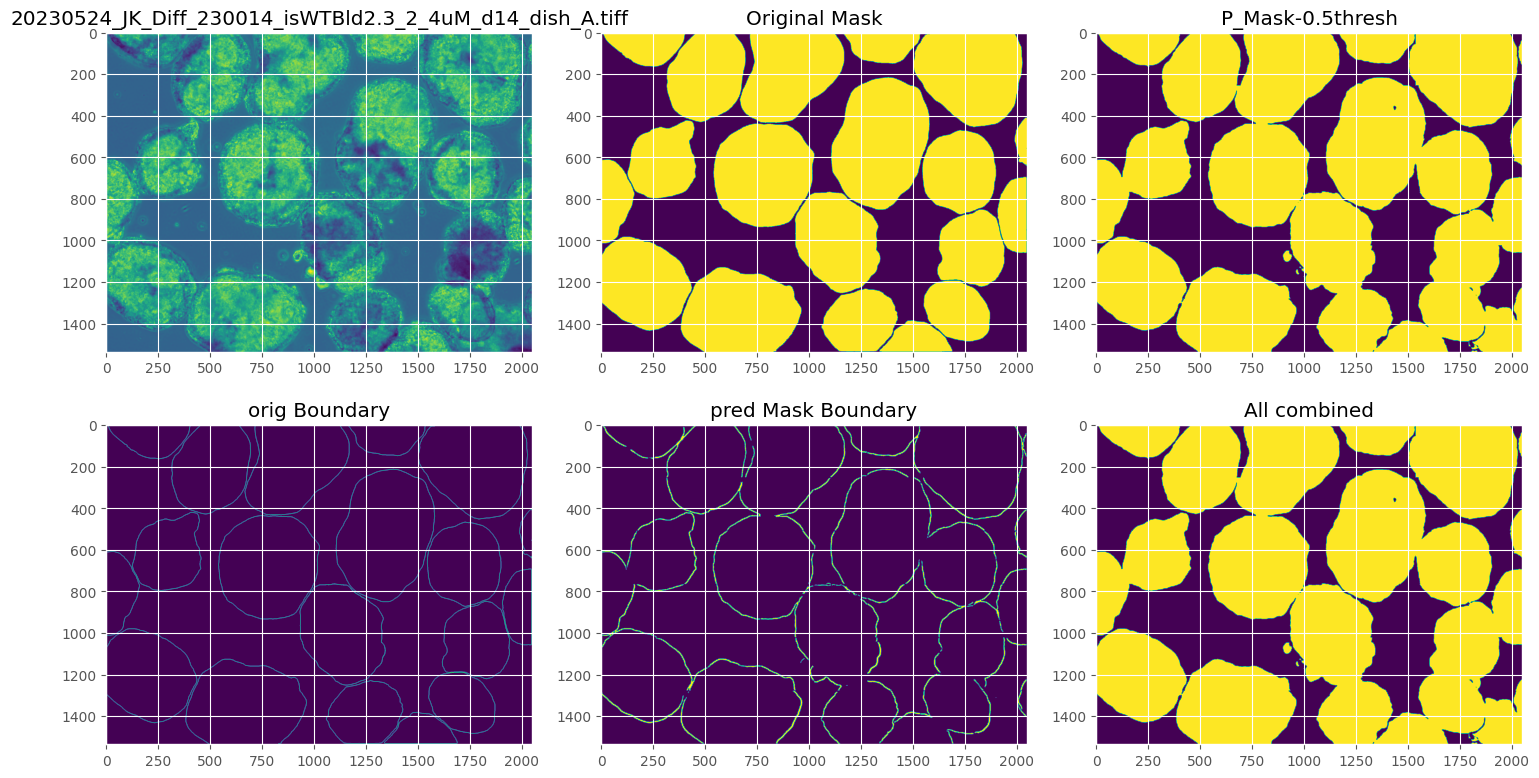

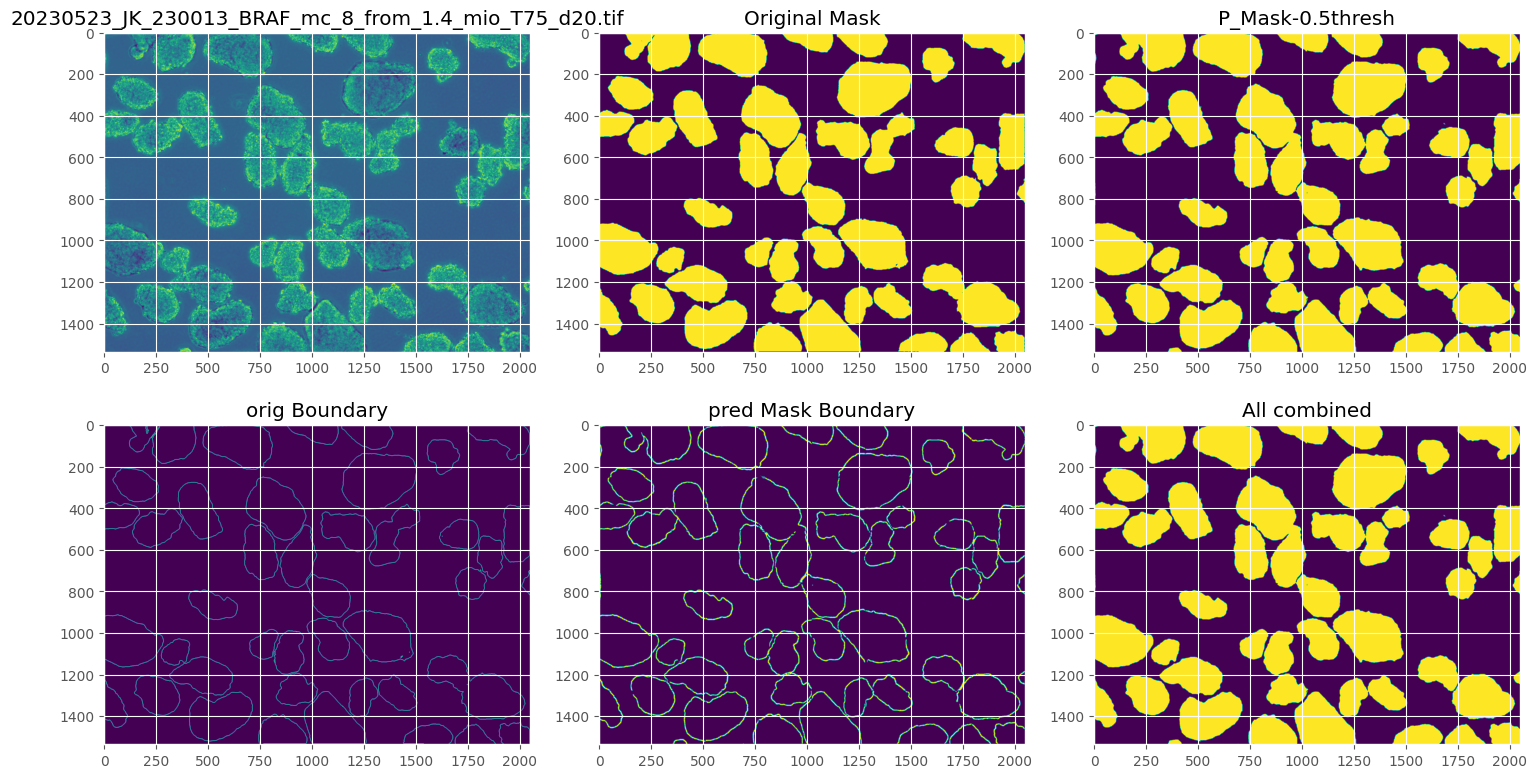

In [16]:
def loadModel(path):
    file = glob.glob("*.pth")
    print(path)
    model = torch.load(path)
    return model 

print("[INFO] load up model...")
# model = torch.load(modelFilePath).to(DEVICE)
model = loadModel(modelFilePath).to(DEVICE)
print("[INFO] loading up test image paths...\n")
test_input = '/kaggle/input/myofarm/test_inputs'
test_mask = '/kaggle/input/myofarm/test_masks'

files = os.listdir(test_input)
for file in files:
    imagePath = test_input+ '/' + file
    groundTruthPath = test_mask + '/' + '.'.join(file.split('.')[:-1]) + '_bn.tif'
    simg = make_predictions(unet, file, imagePath, groundTruthPath, PATCH_SIZE, threshold = 0.5)
#     break